In [1]:
import os
import re
import gzip
import nibabel as nib

import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import CompositionalNets.Initialization_Code.config_initialization as comp_net_init_config
from CompositionalNets.Initialization_Code.comptSimMat import compute_similarity_matrix
import CompositionalNets.Code.config as comp_net_config
from CompositionalNets.Initialization_Code.vMF_clustering import learn_vmf_clusters, save_cluster_images
from CompositionalNets.Initialization_Code.Learn_mix_model_vMF_view import learn_mix_model_vMF

from src.config import directories
from src.models import UNet
from src.dataset import ClassificationDataset, apply_ct_abdomen_filter, NormalizeInstance, Resize

%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

max_images 5000


In [2]:
vol_dir = os.path.join(directories['chaos_registrations'], 'affine', 'out')
regex = re.compile('.*\.nii\.gz')
largest_slices = []

for name in sorted(os.listdir(vol_dir)):
    
    if regex.match(name):
        
        fp = os.path.join(vol_dir, name)
        with gzip.open(fp, 'rb') as f:
            
            vol = nib.load(f.filename)
            vol_array = np.array(vol.dataobj, dtype=np.int16)
            
            num_slices = vol_array.shape[2]
            amount = np.zeros(num_slices)
            
            for i in range(num_slices):
                
                s = vol_array[...,i]
                background = s.min()
                amount[i] = np.sum(s==background)
            
            idx = np.argmin(amount)
            slices = [vol_array[...,i] for i in range(idx-2, idx+3)]
            for largest_slice in slices:
            
#             largest_slice = vol_array[...,np.argmin(amount)]
                largest_slice = apply_ct_abdomen_filter(largest_slice)
                largest_slice = np.rot90(largest_slice, k=1)
                largest_slice = np.stack((largest_slice, largest_slice, largest_slice), axis=2)

                # Normalize between 0 and 1
                largest_slice = (largest_slice - largest_slice.min()) / (largest_slice.max() - largest_slice.min())
                largest_slice = largest_slice.astype(np.float32)
                largest_slices.append(largest_slice)
            
largest_slices = np.asarray(largest_slices)
div = int(len(largest_slices)*0.8)
train_slices = largest_slices[:div]

dataset = ClassificationDataset(train_slices, [0] * len(train_slices), input_transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=1)

/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: use the name attribute
  if sys.path[0] == '':


In [3]:
synthetic_images = []
test_slices = largest_slices[div:].copy()

im = test_slices[1].copy()
# im = im[110:390, 50:380]
# im[150:200, 25:125] = im.min()
im[200:300, 100:200] = im.min()
synthetic_images.append(im)

im = test_slices[2].copy()
# im = im[115:370, 50:420]
# im[50:100, 150:250] = im.min()
im[200:300, 100:200] = im.min()
synthetic_images.append(im)

im = test_slices[3].copy()
# im = im[115:385, 50:420]
# im[120:190, 40:135] = im.min()
im[150:200, 200:300] = im.min()
synthetic_images.append(im)

# im = np.tile(0.0, (512, 512, 3)).astype(np.float32)
# synthetic_images.append(im)

# plt.imshow(im)

In [120]:
vmf, loc_set =  learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
                                     max_it=300, tol=5e-12,
                                     u_out_name='chaos_pool5_128_u_test_2.pickle',
#                                      u_out_name='chaos_pool5_512_u.pickle',
                                     p_out_name='chaos_pool5_128_p_test_2.pickle')
#                                      p_out_name='chaos_pool5_512_p.pickle')

In [ ]:
%%time
mat1, mat2 = compute_similarity_matrix(data_loader, 0, 'test',
                                       sim_dir_name='similarity_vgg_pool5_chaos_2',
                                       u_out_name='chaos_pool5_128_u_test.pickle',
                                       N_sub=16, num_layer_features=80)

Determine best threshold for binarization - 0 ...
Start compute sim matrix ... magicThresh 0.45
iter 1/5 1/5


/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


comptSimMat iter time: 67.1521456281344
iter 1/5 2/5
comptSimMat iter time: 134.98923683961232
iter 1/5 3/5
comptSimMat iter time: 134.92197439670562
iter 1/5 4/5
comptSimMat iter time: 140.97037011384964
iter 1/5 5/5
comptSimMat iter time: 146.695239118735
iter 2/5 2/5


In [10]:
learn_mix_model_vMF(data_loader, 0, sim_matrix_name='test',
                    num_layers=1, num_clusters_per_layer=1,
                    sim_dir_name='similarity_vgg_pool5_chaos_2',
                    dict_filename='chaos_pool5_128_u_test_2.pickle',
                    mixdir_name=f'mix_model_vmf_chaos_EM_all_test_2/',
                    im_channels=3)

total number of instances for obj 0: 16
128 128 128
Clustering layer 0 ...
0 0 16 0
cluster 0 has 16 samples

ML Step 0 / 10
0
cluster 0 has 16 samples
0 changed assignments


# Localize Occluders on Synthetic

In [14]:
from torchvision import models
from PIL import Image
import cv2

from CompositionalNets.Code.config import categories, data_path, device_ids, categories_train, mix_model_path, dict_dir, layer, vMF_kappa, model_save_dir, compnet_type, backbone_type, num_mixtures
from CompositionalNets.Code.config import config as cfg
from CompositionalNets.Code.model import Net
from CompositionalNets.Code.helpers import getVmfKernels, getCompositionModel, update_clutter_model
from CompositionalNets.Code.eval_occlusion_localization import visualize_response_map
from CompositionalNets.Code.losses import ClusterLoss
from CompositionalNets.Initialization_Code.config_initialization import extractor

In [12]:
%%time
occ_likely = [0.6 for _ in range(len(categories_train))]

dict_dir = os.path.join(directories['CompositionalNets'],
                        'models/init_vgg/dictionary_vgg/chaos_pool5_128_u_test_2.pickle')
weights = getVmfKernels(dict_dir, device_ids)
mix_model_path = os.path.join(directories['CompositionalNets'], 
                             'models/init_vgg/mix_model_vmf_chaos_EM_all_test_2/')
mix_models = getCompositionModel(device_ids, mix_model_path, layer, 
                                 [0],
                                 compnet_type=compnet_type,
                                 num_mixtures=num_mixtures)

model = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
            bool_mixture_bg=True,
            compnet_type=compnet_type, num_mixtures=num_mixtures, 
            vc_thresholds=cfg.MODEL.VC_THRESHOLD)
if device_ids:
    model.to(device_ids[0])

Early stop at iter 2, llk 29.432735104273043
CPU times: user 467 ms, sys: 88.7 ms, total: 556 ms
Wall time: 1.5 s


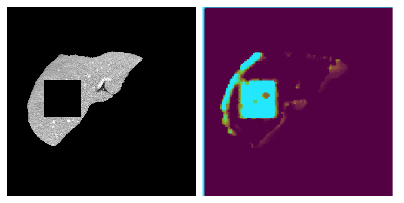

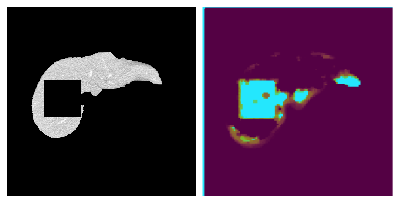

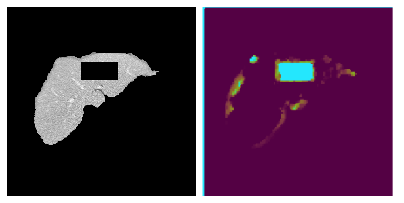

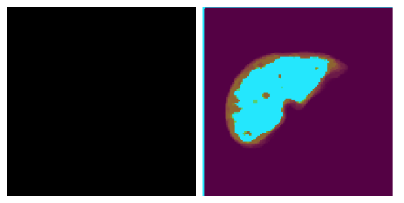

In [34]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
with torch.no_grad():
    for image in synthetic_images:
        
        image = cc(image)
        
        if device_ids:
            image = image.cuda(device_ids[0])
        
        image = image.unsqueeze(0)

        #localize occluder
#         if i == 2: pdb.set_trace() # there's an indexing issue if not using a mixture background
        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0)
        
        # concatenate original image and occluder map
#         img_orig = np.array(Image.fromarray(image_dataset[i], mode='F').convert('RGB'))
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
#         mask = np.array(Image.fromarray(mask.squeeze().numpy()*255//2, mode='F').convert('RGB'))
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
#         mask = cv2.resize(mask, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(canvas)
        plt.axis('off')
        fp = f'{directories["CompositionalNets"]}/results/lits/train_without_occluder/test_{i}.png'
        cv2.imwrite(fp, canvas)

In [66]:
target = largest_slices[2].copy()
target[target != 0] = 1

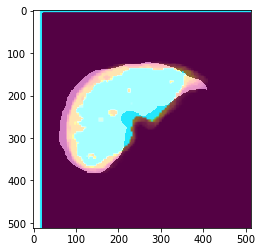

In [114]:
occ_img_new = occ_img_s.copy()
display = cv2.addWeighted((target*255).astype(np.uint8), 0.5, occ_img_new[:,0:512,:], 1, 0)
plt.imshow(display)

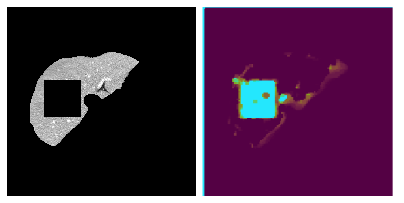

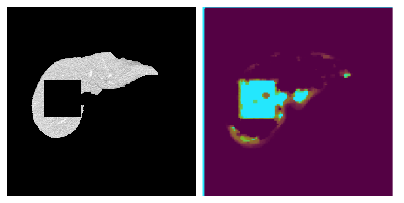

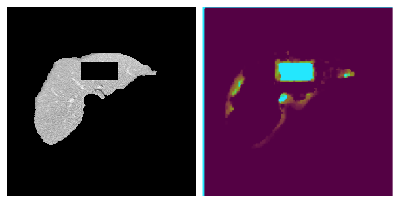

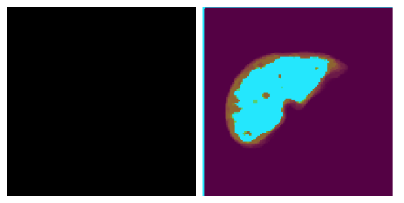

In [75]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

# image = target * synthetic_images[2].copy()

i = 0
with torch.no_grad():
    for image in synthetic_images:
        image = image * target
        image = cc(image)

        if device_ids:
            image = image.cuda(device_ids[0])

        image = image.unsqueeze(0)

        #localize occluder
    #         if i == 2: pdb.set_trace() # there's an indexing issue if not using a mixture background
        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0)

        # concatenate original image and occluder map
    #         img_orig = np.array(Image.fromarray(image_dataset[i], mode='F').convert('RGB'))
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
    #         mask = np.array(Image.fromarray(mask.squeeze().numpy()*255//2, mode='F').convert('RGB'))
        faco = img_orig.shape[0] / occ_img.shape[0]

        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
    #         mask = cv2.resize(mask, (int(occ_img.shape[1] * faco), img_orig.shape[0]))

        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(canvas)
        plt.axis('off')
        fp = f'{directories["CompositionalNets"]}/results/lits/train_without_occluder/test_{i}.png'
        cv2.imwrite(fp, canvas)